In [1]:
import importlib

import src.data_scripts.data_loading as load
import src.data_scripts.data_preprocessing as pre
import src.data_scripts.data_augmentation as aug
import src.ml.metrics as metrics

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import src.ml.models as models

## UnetGAN

In [3]:
input_func_list = [
    pre.resize,
    aug.Augment(aug.random_brightness, prob=0.3),
    aug.Augment(aug.random_saturation, prob=0.3),
    pre.normalize_pixels
]
truth_func_list = [
    pre.resize,
    pre.invert, 
    pre.to_grayscale, 
    pre.normalize_pixels
]

ds_factory = load.FingerprintDatasetFactory(input_func_list, truth_func_list, batch_size=1, seed=42)
train_ds = ds_factory("./small_data/training_input", "./small_data/training_truth")
test_ds = ds_factory("./small_data/validation_input", "./small_data/validation_truth")

augments = [
    aug.Augment(aug.vert_flip_together, prob=0.3),
    aug.Augment(aug.horiz_flip_together, prob=0.3)
]
train_ds = aug.augment_together_dataset(train_ds, augments)

Found 4000 files belonging to 1 classes.
Found 4000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


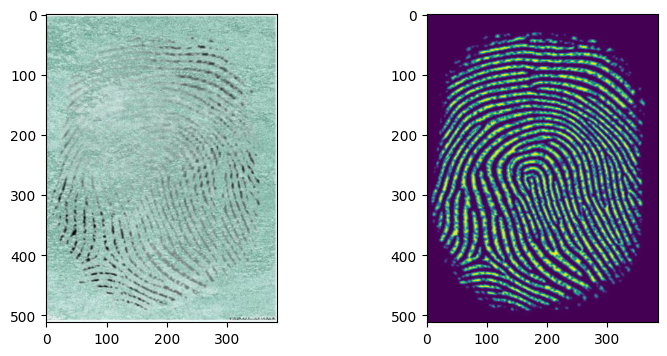

In [7]:
test_input_batch, test_truth_batch = next(test_ds.as_numpy_iterator())
test_input, test_truth = test_input_batch[0], test_truth_batch[0]

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(test_input)
axs[1].imshow(test_truth)
plt.show()

In [17]:
importlib.reload(models)
unet_gan = models.UnetGAN(
    tf.keras.optimizers.Adam(0.001), tf.keras.optimizers.Adam(0.001), img_shape=(512, 384, 3)
)

In [18]:
history = unet_gan.fit(train_ds, test_ds, epochs=1, checkpoint_steps=100)

History:
{'gen_total_loss': [], 'gen_gan_loss': [], 'gen_l1_loss': [], 'disc_loss': []}
Epoch: 0


KeyboardInterrupt: 

In [168]:
test_pred = unet_gan.generator(test_input[np.newaxis], training=False)[0]

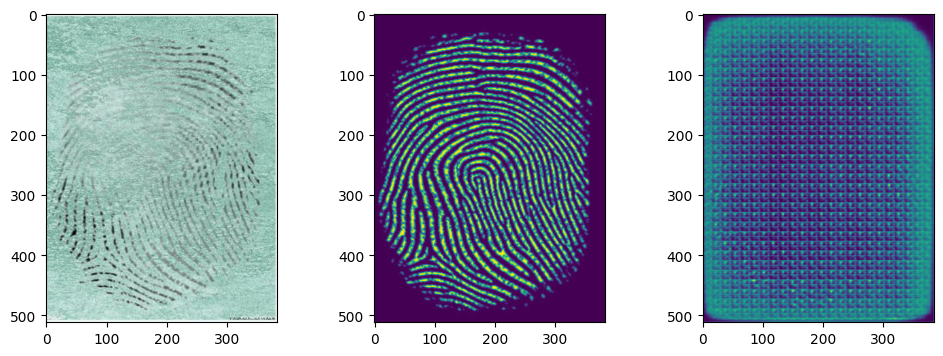

In [169]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(test_input)
axs[1].imshow(test_truth)
axs[2].imshow(test_pred)
plt.show()

## ResNet50 Transfer learning

In [12]:
input_func_list = [
    pre.resize,
    aug.Augment(aug.random_brightness, prob=0.3),
    aug.Augment(aug.random_saturation, prob=0.3)
]
truth_func_list = [
    pre.resize,
    pre.invert, 
    pre.to_grayscale
]

ds_factory = load.FingerprintDatasetFactory(input_func_list, truth_func_list, batch_size=4, seed=42)
train_ds = ds_factory("./small_data/training_input", "./small_data/training_truth")
test_ds = ds_factory("./small_data/validation_input", "./small_data/validation_truth")

Found 4000 files belonging to 1 classes.
Found 4000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.


In [19]:
input_batch, truth_batch = next(train_ds.as_numpy_iterator())
test_input, test_truth = input_batch[0], truth_batch[0]

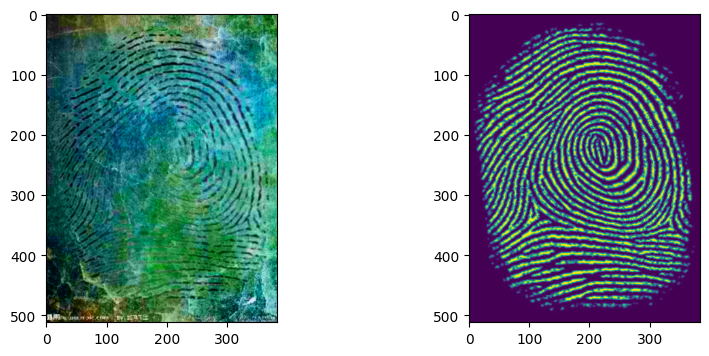

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(input_batch[3].astype(np.uint8))
axs[1].imshow(truth_batch[3].astype(np.uint8))

In [25]:
importlib.reload(models)
resnet_trans = models.get_resnet_transfer()
resnet_trans.compile(
    optimizer=tf.optimizers.Adam(0.01),
    loss="mse",
    metrics=[metrics.SSIMMetric(), metrics.PSNRMetric()]
)
resnet_trans.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 512, 384, 3)]     0         
                                                                 
 tf.__operators__.getitem_6   (None, 512, 384, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_6 (TFOpLambd  (None, 512, 384, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 16, 12, 2048)      23587712  
                                                                 
 conv2d_34 (Conv2D)          (None, 16, 12, 512)       9437696   
                                                                 
 up_sampling2d_28 (UpSamplin  (None, 32, 24, 512)      0   

In [26]:
resnet_trans.get_layer("resnet50").trainable = True

In [27]:
history = resnet_trans.fit(train_ds, validation_data=test_ds, epochs=1)

  65/1000 [>.............................] - ETA: 54:59 - loss: 8068.4780 - ssim: 1.0532e-04 - psnr: -39.0404

KeyboardInterrupt: 

1/1 [==============================] - 0s 368ms/step


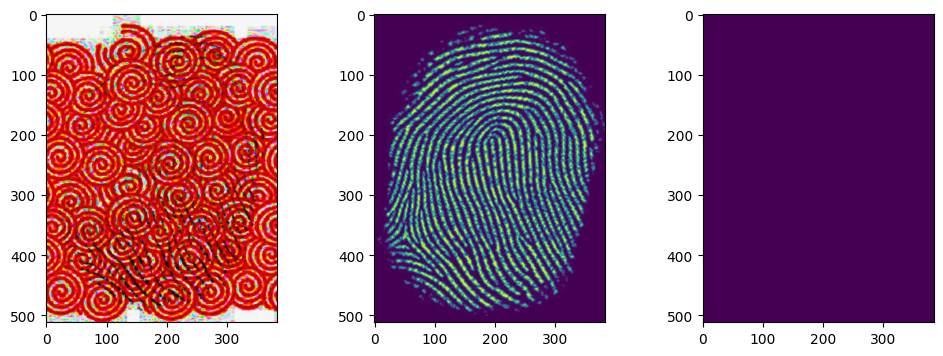

In [22]:
test_pred = resnet_trans.predict(test_input[np.newaxis])[0]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(test_input.astype(np.uint8))
axs[1].imshow(test_truth)
axs[2].imshow(test_pred)
plt.show()

## Custom model

In [2]:
input_func_list = [
    pre.resize,
    pre.normalize_pixels
]
truth_func_list = [
    pre.resize,
    pre.invert, 
    pre.to_grayscale, 
    pre.normalize_pixels
]

ds_factory = load.FingerprintDatasetFactory(input_func_list, truth_func_list, batch_size=4, seed=42)
train_ds = ds_factory("./small_data/training_input", "./small_data/training_truth")
test_ds = ds_factory("./small_data/validation_input", "./small_data/validation_truth")

Found 4000 files belonging to 1 classes.
Found 4000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.


In [6]:
importlib.reload(models)
custom_model = models.get_custom_conv_and_dense(conv_activation="relu")

custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[metrics.SSIMMetric(), metrics.PSNRMetric()]
)

custom_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 512, 384, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 170, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 170, 128, 128)     73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 42, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 56, 42, 256)       295168    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 18, 14, 256)     

In [4]:
history = custom_model.fit(train_ds, validation_data=test_ds, epochs=1)

  83/1000 [=>............................] - ETA: 1:44:37 - loss: 0.1327 - ssim: 0.2247 - psnr: 8.9226

KeyboardInterrupt: 

In [28]:
PATH_TO_INPUT = "./data/training_input"
PATH_TO_TRUTH = "./data/training_ground-truth"
filenames = glob.glob("*", root_dir=PATH_TO_INPUT)

n_examples = 4
fnames = np.random.choice(filenames, n_examples)
imgs_input = np.array([cv2.imread(os.path.join(PATH_TO_INPUT, fname), cv2.IMREAD_UNCHANGED) for fname in fnames], dtype=np.float32) / 255
imgs_truth = 1 - np.array([cv2.imread(os.path.join(PATH_TO_TRUTH, fname), cv2.IMREAD_UNCHANGED) for fname in fnames], dtype=np.float32) / 255

1/1 [==============================] - 0s 347ms/step


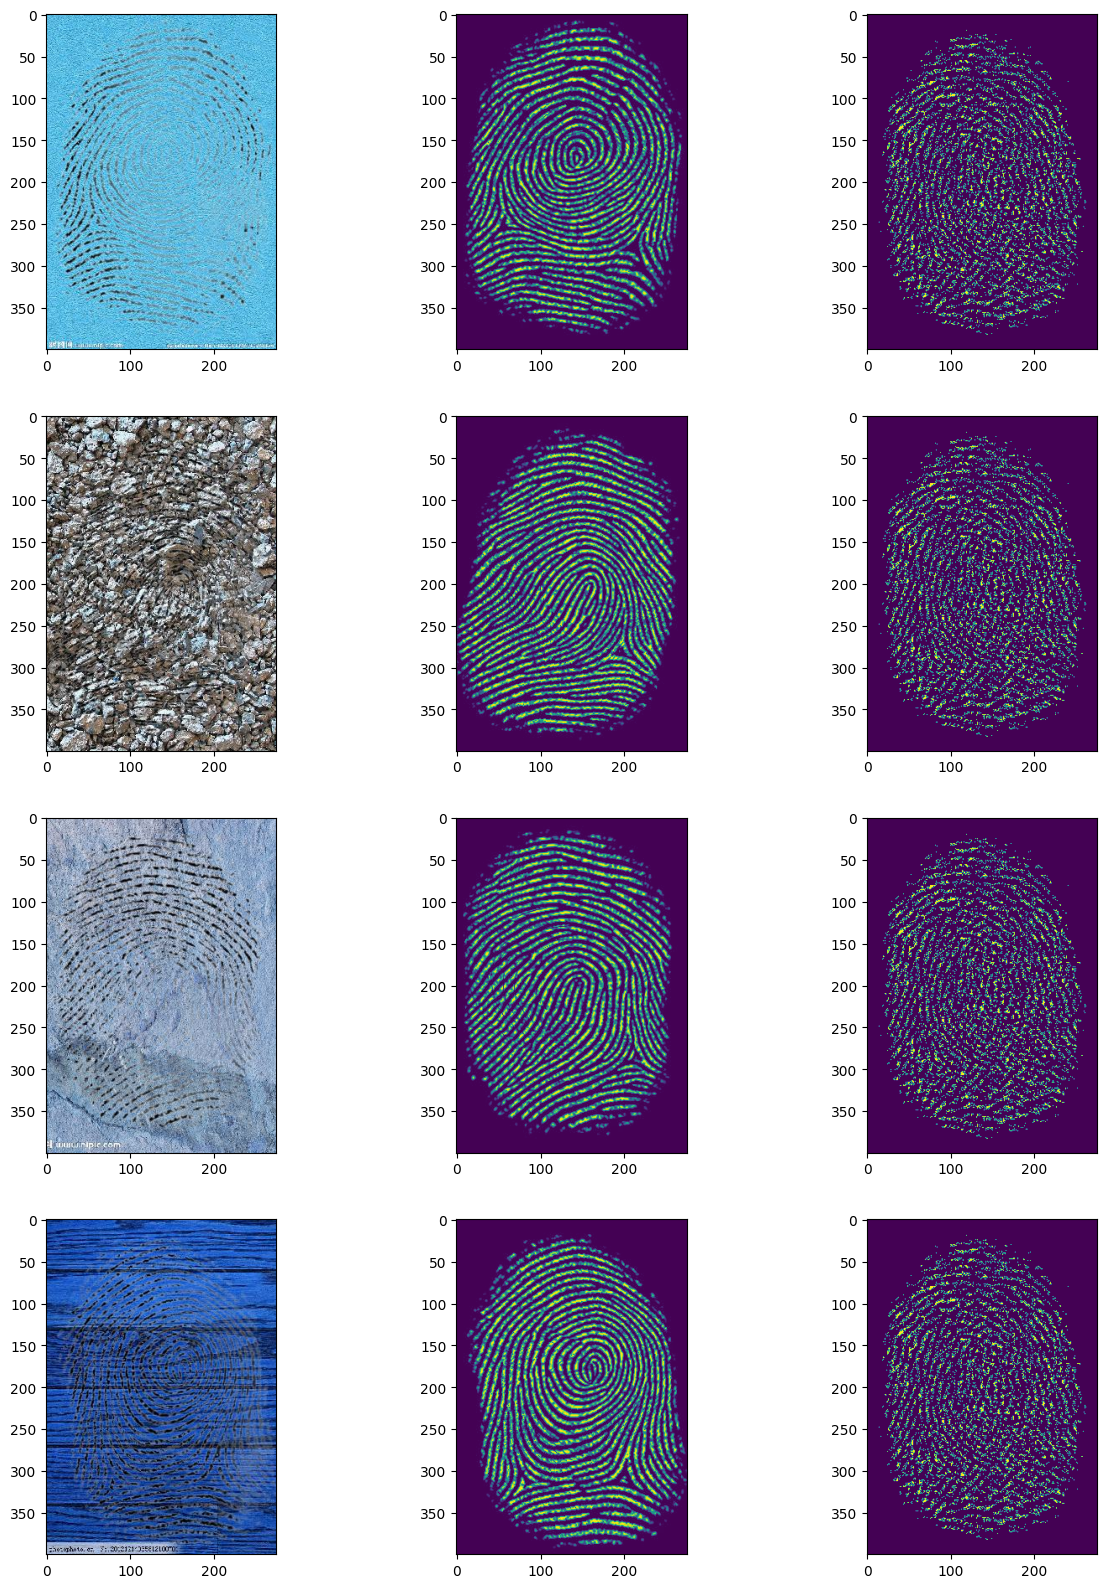

In [15]:
img_predict = custom_model.predict(imgs_input)


fig, axs = plt.subplots(n_examples, 3, figsize=(15, n_examples*5))
for i in range(n_examples):
    axs[i, 0].imshow(imgs_input[i])
    axs[i, 1].imshow(imgs_truth[i])
    axs[i, 2].imshow(img_predict[i])